In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
train = pd.read_csv("preprocessed_train.csv", encoding='euc-kr')

In [153]:
train = train.drop(columns=['분석데이터'], axis=1)

In [154]:
train

,label,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,a_0,...,dist_86,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95
0,1,144,12.298611,1771,5.356616,0,0,0,1,2399,...,10,4,10,9,4,0,1,0,0,0
1,1,804,9.580846,7703,6.063542,0,0,0,6,183376,...,43,121,84,78,47,36,40,45,27,36
2,0,2205,12.736054,28083,6.107050,9,0,0,6,1178,...,326,268,239,286,199,148,154,37,48,36
3,0,2602,10.288240,26770,5.373013,8,0,0,1,56851,...,336,230,206,245,76,0,26,702,1,5
4,1,8980,23.252339,208806,5.775223,0,28,16,3,124274,...,731,882,1171,1010,322,64,327,84,75,244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,2018,13.938057,28127,5.940442,0,70,0,11,255044,...,246,186,206,235,88,33,81,58,61,72
9996,0,1105,16.437104,18163,5.766962,0,11,0,3,181296,...,199,57,134,123,20,25,28,25,41,13
9997,0,4,58.500000,234,3.811827,0,0,0,1,68736,...,0,0,0,0,0,0,0,0,0,0
9998,1,3312,24.939312,82599,5.834730,0,39,0,8,90648,...,438,985,806,851,113,123,181,100,75,86


In [155]:
train_df_x = train.drop(['label'], axis=1)

In [156]:
train_df_y = train['label']

In [157]:
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.2, random_state=42)

In [158]:
xgb_params = {'n_estimators': 10000,
               'learning_rate': 0.03689407512484644,
               'max_depth': 8,
               'colsample_bytree': 0.3723914688159835,
               'subsample': 0.780714581166012,
               'eval_metric': 'auc',
               'use_label_encoder': False,
               'gamma': 0,
               'reg_lambda': 50.0,
               'tree_method': 'gpu_hist',
               'gpu_id': 0,
               'predictor': 'gpu_predictor',
               'random_state': 42 }

lgb_params = {'n_estimators': 10000,
              'learning_rate':0.09416659111369403,
              'max_depth':43,
              'boosting':'gbdt',
              'objective': 'binary',
              'metric': 'binary_logloss',
              'is_training_metric': True,
              'num_leaves':41,
              'min_data_in_leaf':10,
              'feature_fraction':0.8,
              'bagging_fraction':0.9,
              'bagging_freq':0,
              'alpha': 0.019782149081578264 }

cat_params = {'objective': 'CrossEntropy',
              'colsample_bylevel': 0.043529438827711514,
              'depth': 12,
              'boosting_type': 'Ordered',
              'bootstrap_type': 'Bernoulli',
              'learning_rate': 0.19719860541901787,
              'iterations': 205,
              'random_strength': 34,
              'od_type': 'IncToDec',
              'subsample': 0.9558805603499683
             }

In [166]:
lgb_params = {'n_estimators': 20000,
              'learning_rate':0.01}

xgb_params = {'n_estimators': 10000,
               'learning_rate': 0.01,
               'max_depth': 12}

In [160]:
lgbm = LGBMClassifier(**lgb_params)

xgb = XGBClassifier(**xgb_params)

cat = CatBoostClassifier(**cat_params)

In [19]:
rf = RandomForestClassifierdomForestClassifier(n_estimators= 1000)

In [164]:
pred_lgbm = lgbm.fit(x_train, y_train).predict(x_test)

In [167]:
pred_xgb = xgb.fit(x_train, y_train).predict(x_test)

In [20]:
pred_rf = rf.fit(x_train, y_train).predict(x_test)

In [165]:
accuracy_score(y_test, pred_lgbm)

0.9285

LGBM
1. optuna -> 0.925  
2. 'n_estimators': 10000, 'learning_rate': 0.01 -> 0.9285  
3. 'n_estimators': 20000. 'learning_rate': 0.01 -> 0.9285

In [168]:
accuracy_score(y_test, pred_xgb)

0.9205

XGBoost
1. optuna -> 0.9205 
2. 'n_estimators': 10000, 'learning_rate': 0.01, 'max_depth': 12 ->  

In [21]:
accuracy_score(y_test, pred_rf)

0.9005

## Soft Voting

In [15]:
from sklearn.ensemble import VotingClassifier

In [30]:
voting_estimators = [ ('LGBM', lgbm),
                    ('XGB', xgb),
                    ('RandomForest', rf)]

In [31]:
voting_model = VotingClassifier(estimators= voting_estimators, voting='soft')

In [32]:
voting_model.fit(x_train, y_train)
pred_voting = voting_model.predict(x_test)

In [33]:
accuracy_score(y_test, pred_voting)

0.929

## Remove_Outlier (LGBM)

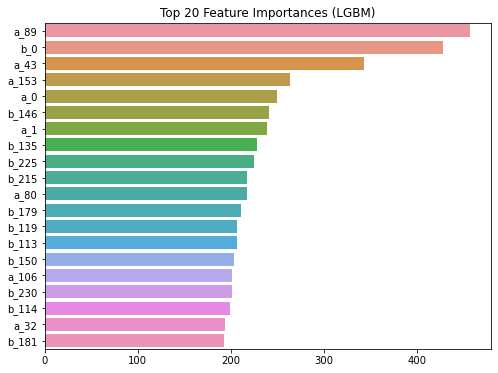

In [104]:
ft_importance_values = lgbm.feature_importances_

ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances (LGBM)')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [125]:
train = pd.read_csv("preprocessed_train.csv", encoding='euc-kr')
train = train.drop(columns=['분석데이터'], axis=1)
train_df_x = train.drop(['label'], axis=1)
train_df_y = train['label']

In [126]:
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.2, random_state=42)

In [127]:
x_train

,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,a_0,a_1,...,dist_86,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95
9254,92,13.500000,1242,5.617271,0,0,0,1,16738,4323,...,9,11,5,12,3,0,2,3,2,0
1561,629,11.941176,7511,6.061898,0,0,0,4,36467,335,...,72,35,84,76,27,13,34,20,21,24
1670,362,5.748619,2081,6.047759,0,0,0,7,393967,32891,...,9,5,8,23,4,19,11,10,7,4
6087,27790,5.742965,159597,6.560686,0,0,0,75,4663,170,...,1796,1502,2255,1308,2056,1381,1569,1239,1632,1320
6669,2042,8.457884,17271,6.306899,0,9,0,3,16454,9185,...,138,138,141,171,114,84,122,99,98,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,728,21.414835,15590,5.339247,0,0,0,1,5083,22,...,151,19,23,172,2,0,0,0,0,0
5191,31774,11.639391,369830,5.401709,0,31,0,1,125002,6049,...,1930,2522,2864,4418,690,381,338,440,231,335
5390,596,7.041946,4197,6.054880,0,0,0,6,220163,20051,...,28,40,19,27,24,18,37,24,11,15
860,205,11.965854,2453,5.786017,0,0,0,1,43248,24338,...,13,15,16,11,1,1,0,1,1,3


In [128]:
outlier_data = pd.concat([x_train, y_train], axis=1)

In [129]:
outlier_data.shape

(8000, 617)

In [130]:
outlier_data

,numstrings,avlength,printables,entropy,paths,urls,registry,MZ,a_0,a_1,...,dist_87,dist_88,dist_89,dist_90,dist_91,dist_92,dist_93,dist_94,dist_95,label
9254,92,13.500000,1242,5.617271,0,0,0,1,16738,4323,...,11,5,12,3,0,2,3,2,0,0
1561,629,11.941176,7511,6.061898,0,0,0,4,36467,335,...,35,84,76,27,13,34,20,21,24,1
1670,362,5.748619,2081,6.047759,0,0,0,7,393967,32891,...,5,8,23,4,19,11,10,7,4,1
6087,27790,5.742965,159597,6.560686,0,0,0,75,4663,170,...,1502,2255,1308,2056,1381,1569,1239,1632,1320,0
6669,2042,8.457884,17271,6.306899,0,9,0,3,16454,9185,...,138,141,171,114,84,122,99,98,82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,728,21.414835,15590,5.339247,0,0,0,1,5083,22,...,19,23,172,2,0,0,0,0,0,1
5191,31774,11.639391,369830,5.401709,0,31,0,1,125002,6049,...,2522,2864,4418,690,381,338,440,231,335,1
5390,596,7.041946,4197,6.054880,0,0,0,6,220163,20051,...,40,19,27,24,18,37,24,11,15,0
860,205,11.965854,2453,5.786017,0,0,0,1,43248,24338,...,15,16,11,1,1,0,1,1,3,1


Text(0.5, 1.0, 'a_89 vs Label')

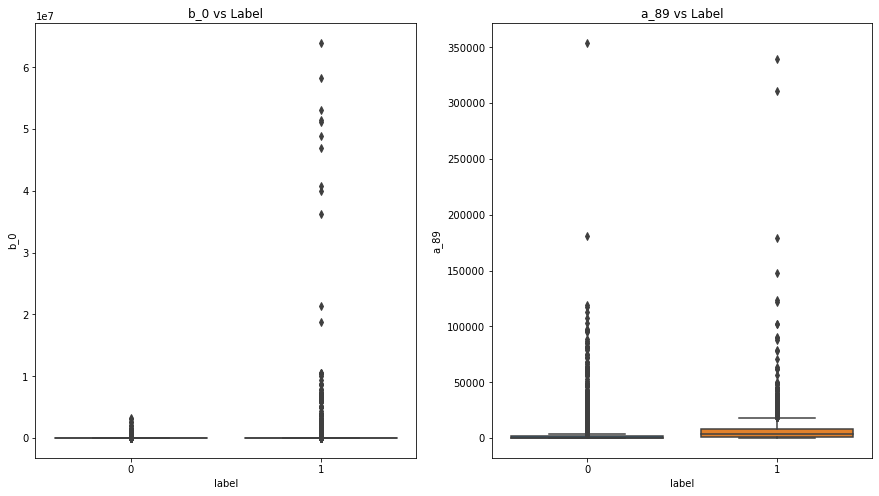

In [131]:
f, axes = plt.subplots(ncols=2, figsize=(15,8))

sns.boxplot(x='label', y='b_0',data=outlier_data, ax=axes[0])
axes[0].set_title('b_0 vs Label')

sns.boxplot(x='label', y='a_89',data=outlier_data, ax=axes[1])
axes[1].set_title('a_89 vs Label')

In [132]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
    
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

In [133]:
outlier_idx = get_outlier(df=outlier_data, column='a_89', weight=1.5)

In [134]:
outlier_data.drop(outlier_idx, axis=0, inplace=True)

In [135]:
outlier_idx = get_outlier(df=outlier_data, column='b_0', weight=1.5)

In [136]:
outlier_data.drop(outlier_idx, axis=0, inplace=True)

In [137]:
x_train = outlier_data.drop(columns=['label'], axis=1)

In [138]:
y_train = outlier_data['label']

In [139]:
x_train.shape, y_train.shape

((6240, 616), (6240,))

In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [144]:
x_train_scaled

array([[-0.47402531, -0.09438057, -0.42125577, ..., -0.24635151,
        -0.39302399, -0.36917917],
       [-0.43981176, -0.10385043, -0.39833036, ..., -0.23200274,
        -0.36766335, -0.33877131],
       [-0.45682297, -0.14147023, -0.41818759, ..., -0.24044319,
        -0.38635014, -0.36411119],
       ...,
       [-0.43350424, -0.04629792, -0.36878588, ..., -0.24888365,
        -0.39569353, -0.36917917],
       [ 1.54451043, -0.10568378,  0.92665126, ...,  0.12249646,
        -0.08736158,  0.05526389],
       [-0.44191427, -0.13361326, -0.41044949, ..., -0.22862655,
        -0.38101105, -0.35017426]])

In [145]:
x_test_scaled

array([[-0.45937146, -0.0885131 , -0.40876363, ..., -0.24297533,
        -0.39569353, -0.36537819],
       [-0.42222714, -0.10601034, -0.3874546 , ..., -0.21765396,
        -0.35698519, -0.32103339],
       [ 4.05025478, -0.09782066,  2.93723013, ...,  0.74287006,
         1.11927083,  1.04732036],
       ...,
       [-0.26887144, -0.02509949, -0.12416168, ..., -0.16447908,
        -0.29558575, -0.26021767],
       [ 2.78575509, -0.10702849,  1.71440533, ...,  0.5960061 ,
         1.00581535,  0.91808695],
       [-0.11092844, -0.07561163, -0.07447473, ..., -0.1594148 ,
        -0.32094639, -0.12971726]])

In [146]:
pred_outlier = lgbm.fit(x_train_scaled, y_train).predict(x_test_scaled)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [147]:
accuracy_score(y_test, pred_outlier)

0.8915